# Observable 3

En este notebook se describen los análisis realizados sobre los espacios de parametros derivados del observable 3.


* esp 1: $\rho^{450}_{\mu}$ y $X^{Rd}_{max}$


* esp 2: $\dfrac{\rho^{450}_{\mu}}{X^{Rd}_{max}}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, E$_{true}$ y $\theta$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, E$_{true}$, $\theta$ y estaciones de radio.

In [2]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import svm
import os

In [3]:
def MeritFactor(v1, v2):
    #Calculo de MF
    muF, stdF = norm.fit(v1)
    muP, stdP = norm.fit(v2)
    #muF, stdF = np.mean(v1), np.std(v1)
    #muP, stdP = np.mean(v2), np.std(v2)
    MF = np.abs(muF - muP) / (np.sqrt(pow(stdF,2) + pow(stdP,2)))
    return MF

In [4]:
def boostMF(v1, v2):
    vv=[]
    size=int(len(v1))
    for i in range(20000):
        #np.random.seed(seed=None)
        samplexF = np.random.choice(v1, size=int(size*0.90), replace=True)
        samplexP = np.random.choice(v2, size=int(size*0.90), replace=True)
        MF = MeritFactor(np.array(samplexP), np.array(samplexF))
        vv.append(np.abs(MF))
    
    avg, std = norm.fit(vv)
    return "%.2f"%avg, "%.2f"%std

In [5]:
# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

# Where to save the figures
PROJECT_ROOT_DIR = "/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/"
#CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, figsize=(10,8))

In [6]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [7]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    pres = cross_val_score(model, X, y, cv=10, scoring="precision");
    recl = cross_val_score(model, X, y, cv=10, scoring="recall");
    F1 = 2/((1/pres)+(1/recl))
    print("Accuracy: ", scoresGauTrain.mean(), scoresGauTrain.std())
    print("presicion: ", pres.mean(), pres.std())
    print("recall: ", recl.mean(), recl.std())
    print("F1_score: ", F1.mean(), F1.std())

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

def auc_cv(X, y, model):
    model = model
    X = np.array(X)
    y = np.array(y)
    random_state = np.random.RandomState(369)

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)

    tprs = []
    for i, (train, train) in enumerate(cv.split(X, y)):
        viz = roc_auc_score(y[train], model.predict_proba(X[train])[:, 1])
        tprs.append(viz)

    print(np.mean(tprs), np.std(tprs))

In [9]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=10)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

In [10]:
#Funcion para calcular la energia con GeoCeLDF
def GeoCeEnergy(RadEnergy, Alpha):
    d = 2.3137 * 1e14   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    c = 0.505
    E = d * pow(RadEnergy / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c)
    #return list(E)
    return np.array(E)
 
def GeoCeEnergyError(RadEnergy, RadEnergyError, Alpha):
    c = 0.505   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    errorE = pow(1 / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c) * pow(RadEnergy, c - 1) * RadEnergyError
    return errorE

In [11]:
#A partir de aquí python sabe en que carpeta se encuentran los datos
os.chdir("/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData/")
os.getcwd()

'/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData'

In [12]:
#Cargando datos
df= pd.read_csv(r"CutEvents_IronRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")
dp= pd.read_csv(r"CutEvents_ProtonRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")

In [13]:
print(df.shape, dp.shape)

(305, 59) (305, 59)


In [14]:
#angulo alfa
AlphaFe=df['lorentz angle']
AlphaFe=np.array(AlphaFe)
AlphaPr=dp['lorentz angle']
AlphaPr=np.array(AlphaPr)

#radiation energy
RadEGeoCeFe=df['GeoCe Erad']
RadEGeoCeFe=np.array(RadEGeoCeFe)
RadEGeoCePr=dp['GeoCe Erad']
RadEGeoCePr=np.array(RadEGeoCePr)

#radiation energy error
RadEGeoCeFe_err=df['GeoCe Erad Error']
RadEGeoCeFe_err=np.array(RadEGeoCeFe_err)
RadEGeoCePr_err=dp['GeoCe Erad Error']
RadEGeoCePr_err=np.array(RadEGeoCePr_err)

#Energia Rd
GeoCeEnergyFe=GeoCeEnergy(RadEGeoCeFe,AlphaFe)
GeoCeEnergyFe_err=GeoCeEnergyError(RadEGeoCeFe, RadEGeoCeFe_err, AlphaFe)
GeoCeEnergyPr=GeoCeEnergy(RadEGeoCePr,AlphaPr)
GeoCeEnergyPr_err=GeoCeEnergyError(RadEGeoCePr,RadEGeoCePr_err, AlphaPr)

df["EnergyRd"] = GeoCeEnergyFe
dp["EnergyRd"] = GeoCeEnergyPr

In [15]:
#Inclusion del target

df["Mu_Xmax"] = df["N_mu_ref"]/df["GeoCeXmax"]
dp["Mu_Xmax"] = dp["N_mu_ref"]/dp["GeoCeXmax"]

df["target"] = df["Rd rec success"]
dp["target"] = dp["Rd rec success"]*0

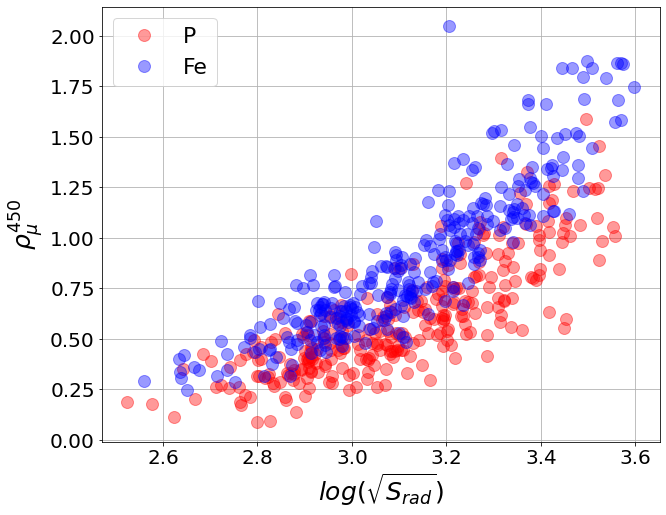

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(np.log10(np.sqrt(df["GeoCe Erad"])), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.log10(np.sqrt(dp["GeoCe Erad"])), df['N_mu_ref'],  'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()
plt.show()

<AxesSubplot:>

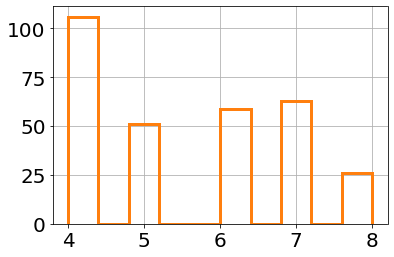

In [17]:
#Iron
df["antennas_cut"] = pd.cut(df["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

df["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

#Proton

dp["antennas_cut"] = pd.cut(dp["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

dp["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

In [18]:
df["antennas_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: antennas_cut, dtype: int64

In [19]:
#### Iron

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=224466)
for train_index, test_index in split.split(df, df["antennas_cut"]):
    train_set_fe = df.loc[train_index]
    test_set_fe = df.loc[test_index]
    
train_set_fe=train_set_fe.drop(["antennas_cut"], axis=1)
test_set_fe=test_set_fe.drop(["antennas_cut"], axis=1)
print(train_set_fe.shape, test_set_fe.shape)

(244, 62) (61, 62)


In [20]:
#### Proton

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(dp, dp["antennas_cut"]):
    train_set_pr = dp.loc[train_index]
    test_set_pr = dp.loc[test_index]
    
train_set_pr=train_set_pr.drop(["antennas_cut"], axis=1)
test_set_pr=test_set_pr.drop(["antennas_cut"], axis=1)
print(train_set_pr.shape, test_set_pr.shape)

(244, 62) (61, 62)


In [21]:
### Contanetando data set
f_train = [train_set_fe, train_set_pr]
f_test = [test_set_fe, test_set_pr]

df_train_ = pd.concat(f_train)
df_test_ = pd.concat(f_test)

print(df_train_.shape, df_test_.shape)
df_train_.head()

(488, 62) (122, 62)


,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,MLDF Chi2,MLDF NDF,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd,Mu_Xmax,target
246,104205,3.824250e+17,50.0277,332.231,606.878,449654,6113980.0,1468.62,1,3.718930e+17,...,16.6122,15,10.3269,0.625931,0.309216,0,0.342569,2.963127e+17,0.001393,1
76,101420,7.590210e+17,50.6696,252.789,615.647,448851,6114320.0,1478.28,1,5.112060e+17,...,29.1496,26,17.2197,0.964079,0.189909,0,0.304324,5.784101e+17,0.001662,1
171,102730,6.116010e+17,40.6307,285.853,616.988,449204,6114370.0,1473.42,1,4.199210e+17,...,26.5052,24,17.0630,0.588354,0.280413,0,0.328039,4.665071e+17,0.001714,1
191,103178,3.842740e+17,53.6568,218.822,601.143,450980,6114150.0,1460.45,1,2.665860e+17,...,15.0781,15,10.9482,0.000097,2.893310,0,0.445807,3.314039e+17,0.001072,1
75,101416,9.452550e+17,49.0955,355.084,636.076,449628,6113950.0,1467.00,1,6.682260e+17,...,21.4435,27,10.3834,1.490790,0.183751,0,0.765089,7.529746e+17,0.002056,1


In [22]:
df_train = df_train_.copy()
df_test = df_test_.copy()

In [23]:
#Features

df_train_1 = df_train[["GeoCeXmax", "N_mu_ref", "target"]]
df_test_1 = df_test[["GeoCeXmax", "N_mu_ref", "target"]]

In [24]:
print(df_train_1.shape, df_test_1.shape)

(488, 3) (122, 3)


In [25]:
df_train_1.head()

,GeoCeXmax,N_mu_ref,target
246,610.506,0.850606,1
76,670.556,1.114180,1
171,669.154,1.146870,1
191,571.015,0.612265,1
75,599.145,1.232080,1


In [26]:
corr_matrix = df_train_1.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [27]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_1.drop("target", axis=1) 
df_train_labels = df_train_1["target"].copy()

df_test_aux = df_test_1.drop("target", axis=1) 
df_test_labels = df_test_1["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_test_aux.shape, df_test_labels.shape)

(488, 2) (488,) (122, 2) (122,)


In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [29]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [30]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [32]:
X_train.head()

,GeoCeXmax,N_mu_ref
0,-0.751797,0.462230
1,0.260940,1.066291
2,0.238489,1.133262
3,-1.481640,-0.224563
4,-0.956135,1.301173


In [33]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

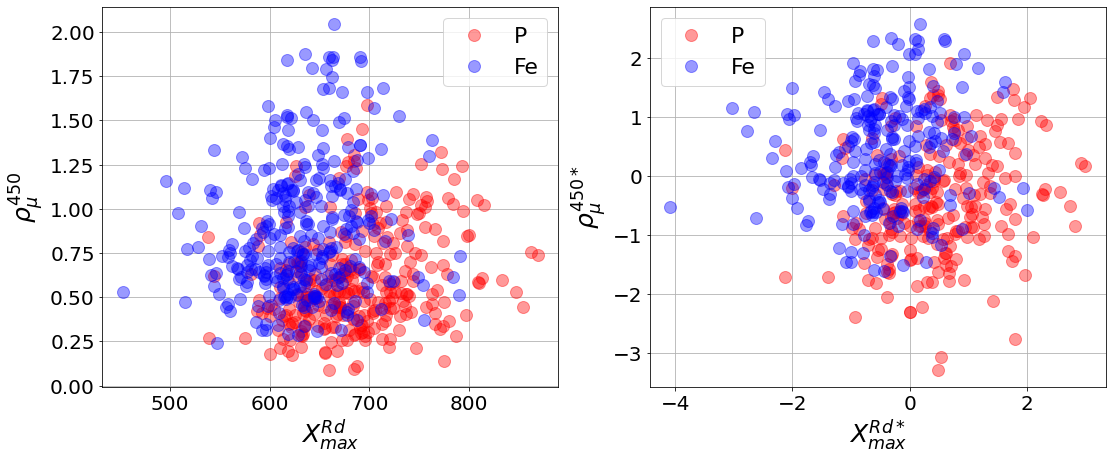

In [34]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(dp["GeoCeXmax"], dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df["GeoCeXmax"], df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$X^{Rd}_{max}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$X^{Rd*}_{max}$", fontsize=25)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [35]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(dp["GeoCeXmax"], dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(df["GeoCeXmax"], df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$X^{Rd}_{max}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$X^{Rd}_{max}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(500, 1000, 25)
    plt.hist(dp["GeoCeXmax"], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df["GeoCeXmax"], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$X^{Rd}_{max}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 20)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$X^{Rd*}_{max}$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

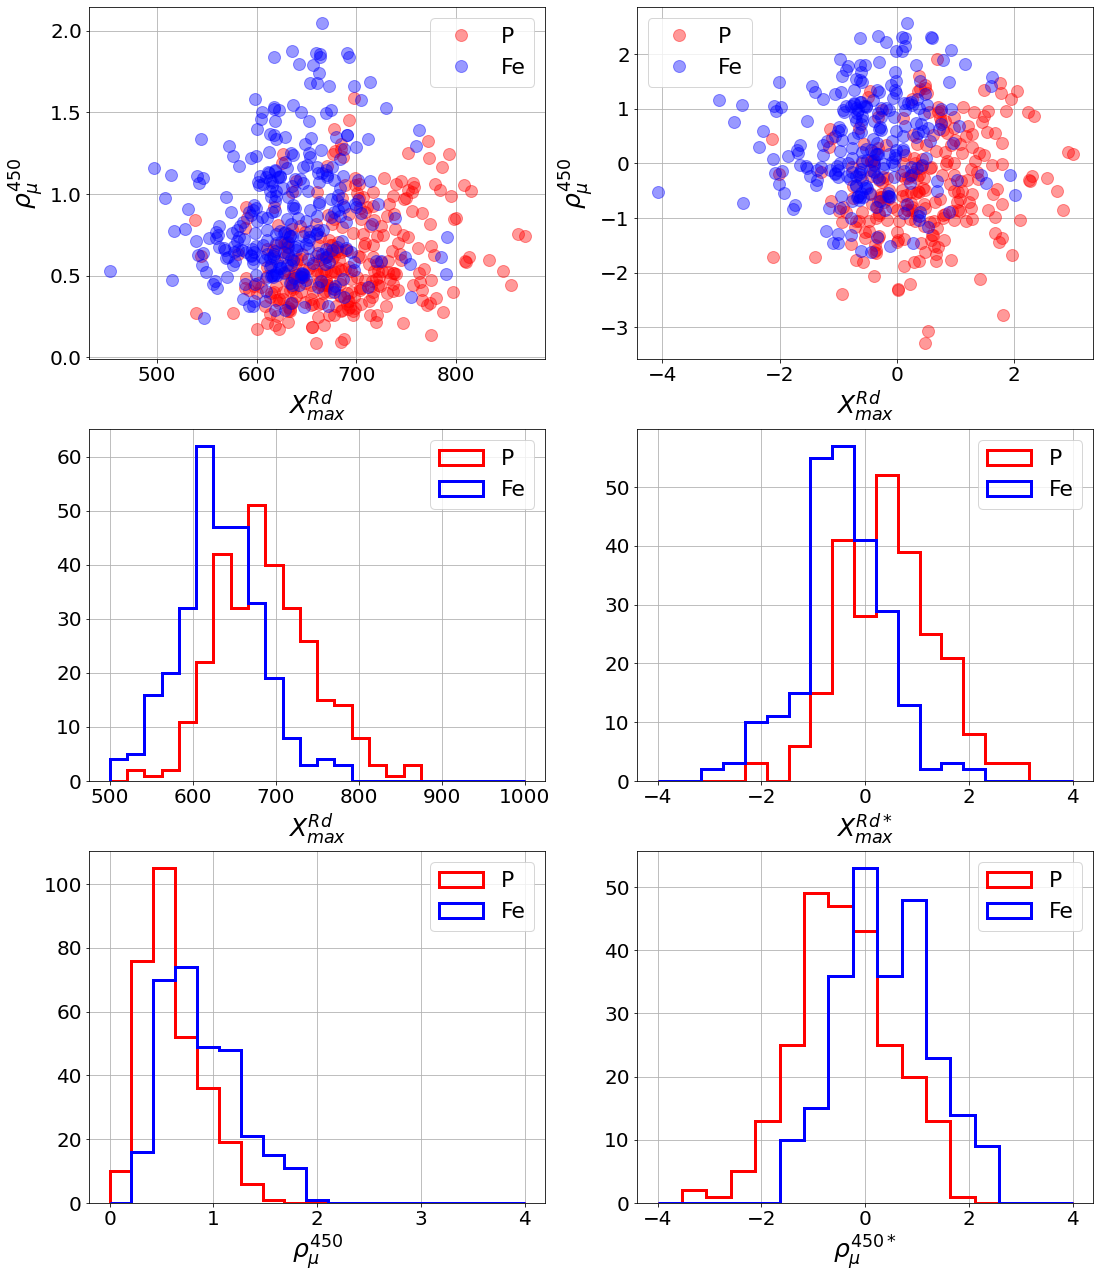

In [36]:
escala(PowerTransformer(method='box-cox'))

In [37]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [37]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [38]:
model_Log_1 = rnd_search_cv.best_estimator_
model_Log_1

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.0751738520495824, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [39]:
print(accuracy(X_train, y_train, model_Log_1))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.7991803278688525
Accuracy:  0.7991496598639455 0.0861439466027899
presicion:  0.8016500772535254 0.08023221115552662
recall:  0.7951666666666667 0.11614992705790028
F1_score:  0.796082834996514 0.09039781174904651
None


In [40]:
mconfusion(X_train, y_train, model_Log_1)

Matriz de confusión, 

[[196  48]
 [ 50 194]]
precisión:  0.8016528925619835
exhaustividad:  0.7950819672131147


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       244
           1       0.80      0.80      0.80       244

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488



In [42]:
ypred = cross_val_predict(model_Log_1, X_train, y_train, cv=5, method="decision_function")

In [43]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

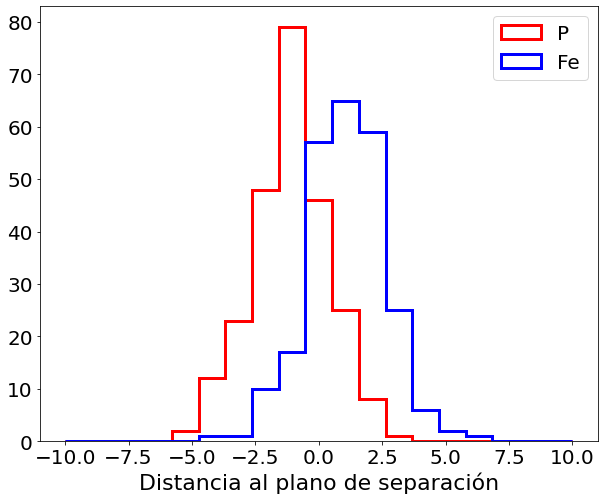

In [44]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [45]:
boostMF(c1_pred, c2_pred)

('1.04', '0.08')

In [46]:
lr=model_Log_1.named_steps['logi_clf']

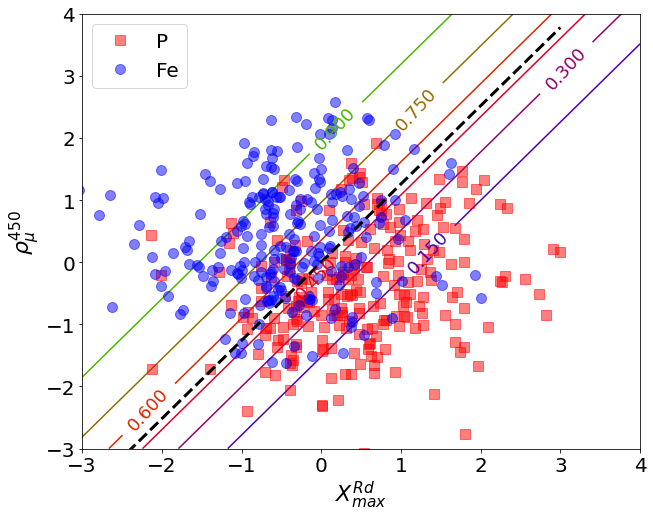

In [47]:
X=X_train
y=y_train

log_reg = model_Log_1.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 4, 500).reshape(-1, 1),
        np.linspace(-3, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{Rd}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=22)
plt.axis([-3, 4, -3, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [50]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [51]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=300, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [52]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=515.6960199099243, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [53]:
print(accuracy(X_poly2, y_train, model_Log_2))
print(crossAccuracy(X_poly2, y_train, model_Log_2))

0.7971311475409836
Accuracy:  0.7909863945578232 0.09481334461943153
presicion:  0.7991021622056105 0.09475292628841064
recall:  0.7791666666666667 0.11849109202336218
F1_score:  0.7867648698826238 0.09945914998154404
None


In [54]:
mconfusion(X_poly2, y_train, model_Log_2)

Matriz de confusión, 

[[196  48]
 [ 54 190]]
precisión:  0.7983193277310925
exhaustividad:  0.7786885245901639


In [55]:
print(classification_report(y_train, model_Log_2.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       244
           1       0.80      0.79      0.80       244

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488



In [56]:
ypred = cross_val_predict(model_Log_2, X_poly2, y_train, cv=5, method="decision_function")

In [57]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

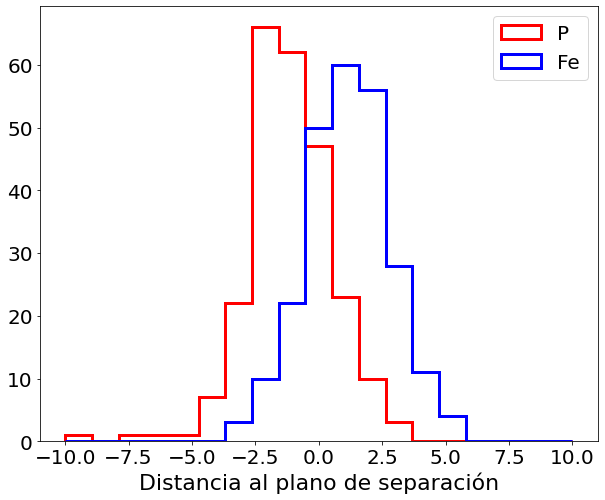

In [58]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [59]:
boostMF(c1_pred, c2_pred)

('1.02', '0.08')

## SVM

In [60]:
from sklearn import svm

In [61]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [62]:
model_svm_1 = rnd_search_cv.best_estimator_
model_svm_1

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.815539706564966, break_ties=False, cache_size=200,
                     class_weight=None, coef0=9.51976930829954,
                     decision_function_shape='ovr', degree=3,
                     gamma=3.290609737189091e-06, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [63]:
print(accuracy(X_train, y_train, model_svm_1))
print(crossAccuracy(X_train, y_train, model_svm_1))

0.8012295081967213
Accuracy:  0.7970663265306122 0.08554186146861197
presicion:  0.8043340599375082 0.08033572948555179
recall:  0.7868333333333333 0.1219368005703501
F1_score:  0.7921754380456387 0.09090434592780781
None


In [64]:
mconfusion(X_train, y_train, model_svm_1)

Matriz de confusión, 

[[197  47]
 [ 52 192]]
precisión:  0.803347280334728
exhaustividad:  0.7868852459016393


In [65]:
print(classification_report(y_train, model_svm_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       244
           1       0.80      0.80      0.80       244

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488



In [66]:
ypred = cross_val_predict(model_svm_1, X_train, y_train, cv=5, method="decision_function")

In [67]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

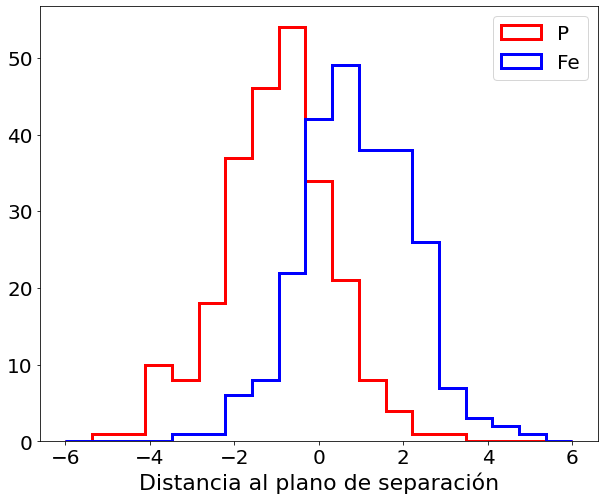

In [68]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [69]:
boostMF(c1_pred, c2_pred)

('1.04', '0.08')

In [70]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [71]:
model_svm_1p = rnd_search_cv.best_estimator_
model_svm_1p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.749574243945933, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [72]:
print(accuracy(X_train, y_train, model_svm_1p))
print(crossAccuracy(X_train, y_train, model_svm_1p))

0.7745901639344263
Accuracy:  0.7850340136054422 0.08970649149382763
presicion:  0.7687620712620713 0.08837079398856959
recall:  0.8243333333333334 0.11683844496663853
F1_score:  0.7919932438048075 0.08706902331941592
None


In [73]:
mconfusion(X_train, y_train, model_svm_1p)

Matriz de confusión, 

[[182  62]
 [ 43 201]]
precisión:  0.7642585551330798
exhaustividad:  0.8237704918032787


In [74]:
print(classification_report(y_train, model_svm_1p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       244
           1       0.74      0.85      0.79       244

    accuracy                           0.77       488
   macro avg       0.78      0.77      0.77       488
weighted avg       0.78      0.77      0.77       488



In [75]:
ypred = cross_val_predict(model_svm_1p, X_train, y_train, cv=5, method="decision_function")

In [76]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

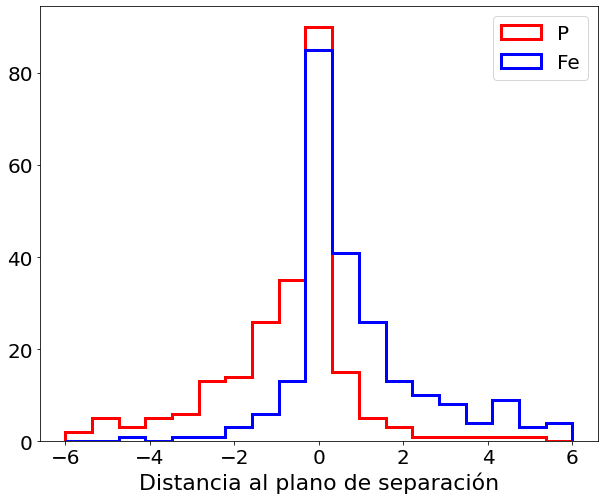

In [77]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [78]:
boostMF(c1_pred, c2_pred)

('0.66', '0.05')

In [54]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(1, 1000), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [55]:
model_svm_2 = rnd_search_cv.best_estimator_
model_svm_2

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=279.5200518320181, break_ties=False, cache_size=200,
                     class_weight=None, coef0=35.544117596640646,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00011837268599840043, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [124]:
print(accuracy(X_train, y_train, model_svm_2))
print(crossAccuracy(X_train, y_train, model_svm_2))

0.8954918032786885
Accuracy:  0.9036989795918368 0.04767187985737514
presicion:  0.8820210032346465 0.04991763376835391
recall:  0.9341666666666667 0.05298977888863725
F1_score:  0.9066924979278477 0.04568356658283868
None


In [125]:
mconfusion(X_train, y_train, model_svm_2)

Matriz de confusión, 

[[213  31]
 [ 16 228]]
precisión:  0.8803088803088803
exhaustividad:  0.9344262295081968


In [58]:
print(classification_report(y_train, model_svm_2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       244
           1       0.87      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [59]:
ypred = cross_val_predict(model_svm_2, X_train, y_train, cv=5, method="decision_function")

In [60]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

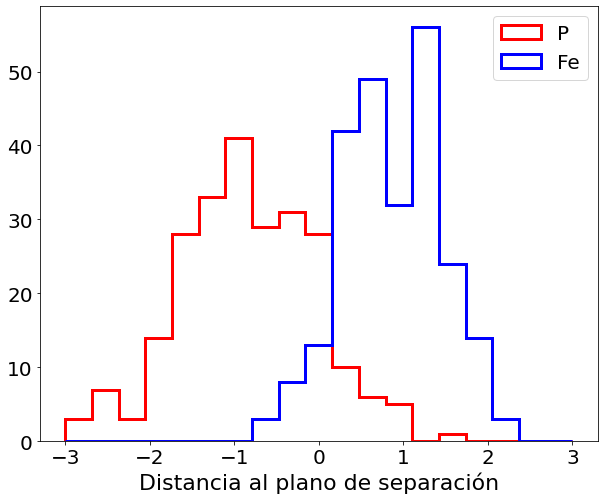

In [61]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-3, 3, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [62]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [63]:
svcP=model_svm_2.named_steps['svm_clf']

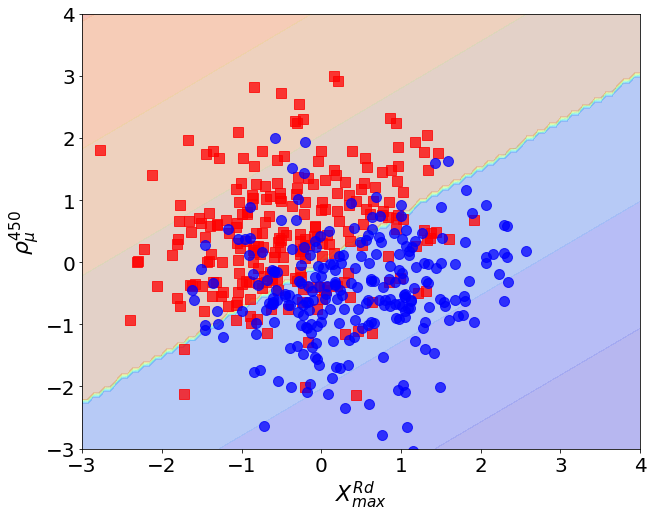

In [65]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 1], XX[yy==0, 0], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 1], XX[yy==1, 0], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_2,[-3, 4, -3, 7])
plot_dataset(XX, yy,[-3, 4, -3, 4])
plt.xlabel(r"$X^{Rd}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu}$")

plt.show()

## Incluyendo la energía

In [126]:
#Features

df_train_2 = df_train[["MC energy", "Mu_Xmax", "target"]]
df_test_2 = df_test[["MC energy", "Mu_Xmax", "target"]]

In [127]:
print(df_train_2.shape, df_test_.shape)

(488, 3) (122, 62)


In [128]:
df_train_2.head()

,MC energy,Mu_Xmax,target
246,3.824250e+17,0.001393,1
76,7.590210e+17,0.001662,1
171,6.116010e+17,0.001714,1
191,3.842740e+17,0.001072,1
75,9.452550e+17,0.002056,1


In [129]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
Mu_Xmax      0.463122
MC energy   -0.005095
Name: target, dtype: float64

In [130]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [131]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [132]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [133]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [134]:
X_train.head()

,MC energy,Mu_Xmax
0,-0.324464,0.596183
1,1.092195,0.983190
2,0.651643,1.053020
3,-0.314309,0.049550
4,1.534527,1.473723


In [135]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 10)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [136]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.20874613782729137, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [137]:
print(accuracy(X_train, y_train, model_Log_3))
print(crossAccuracy(X_train, y_train, model_Log_3))

0.9016393442622951
Accuracy:  0.9036989795918368 0.044974573398954824
presicion:  0.885187669901313 0.0478109520982945
recall:  0.93 0.05256213254594772
F1_score:  0.9062673278598206 0.04299707751663777
None


In [138]:
print(crossAccuracy(X_test, y_test, model_Log_3))

Accuracy:  0.8371794871794871 0.1212267451282318
presicion:  0.8169047619047619 0.11503942930484565
recall:  0.869047619047619 0.1449255027955543
F1_score:  0.8399067599067598 0.12300806861166606
None


In [139]:
mconfusion(X_train, y_train, model_Log_3)

Matriz de confusión, 

[[214  30]
 [ 17 227]]
precisión:  0.8832684824902723
exhaustividad:  0.930327868852459


In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [141]:
ypred = cross_val_predict(model_Log_3, X_train, y_train, cv=5, method="decision_function")

In [142]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

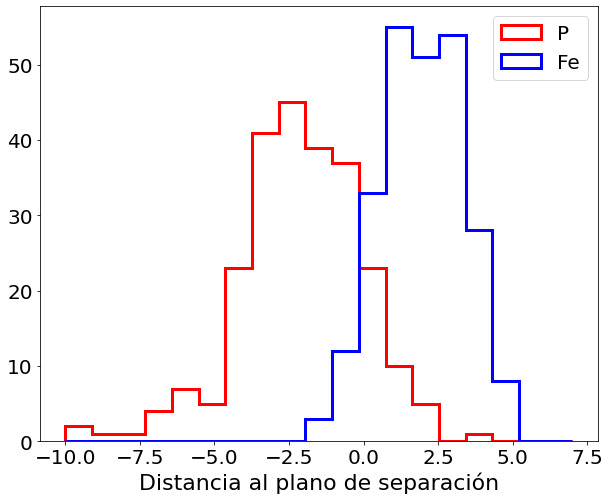

In [143]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 7, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [144]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [149]:
lr=model_Log_3.named_steps['logi_clf']

In [150]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

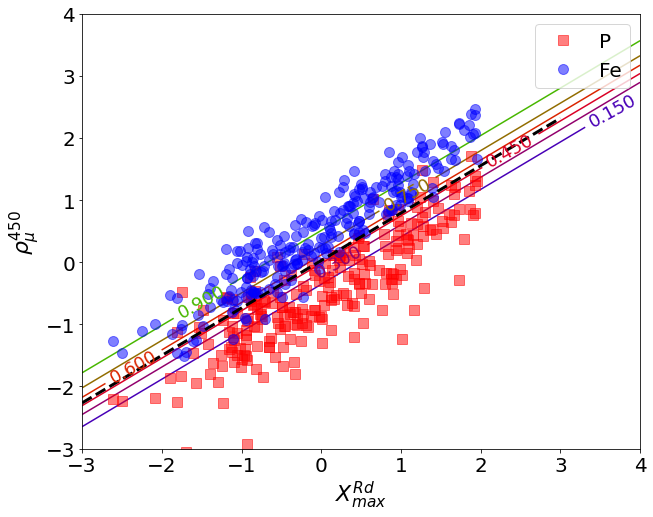

In [152]:
X=X_train
y=y_train

log_reg = model_Log_3.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 4, 500).reshape(-1, 1),
        np.linspace(-3, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{Rd}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=22)
plt.axis([-3, 4, -3, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [111]:
from sklearn.preprocessing import PolynomialFeatures

In [112]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [113]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [114]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=300, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [115]:
model_Log_4 = rnd_search_cv.best_estimator_
model_Log_4

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=8.378886406020703, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [116]:
print(accuracy(X_poly2, y_train, model_Log_4))
print(crossAccuracy(X_poly2, y_train, model_Log_4))

0.8995901639344263
Accuracy:  0.8974914965986395 0.043184576343550676
presicion:  0.8809948216867257 0.04606499136319236
recall:  0.9216666666666665 0.060083275543199206
F1_score:  0.8996709755353567 0.04236578294891547
None


In [117]:
mconfusion(X_poly2, y_train, model_Log_4)

Matriz de confusión, 

[[213  31]
 [ 19 225]]
precisión:  0.87890625
exhaustividad:  0.9221311475409836


In [118]:
print(classification_report(y_train, model_Log_4.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [119]:
ypred = cross_val_predict(model_Log_4, X_poly2, y_train, cv=5, method="decision_function")

In [120]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

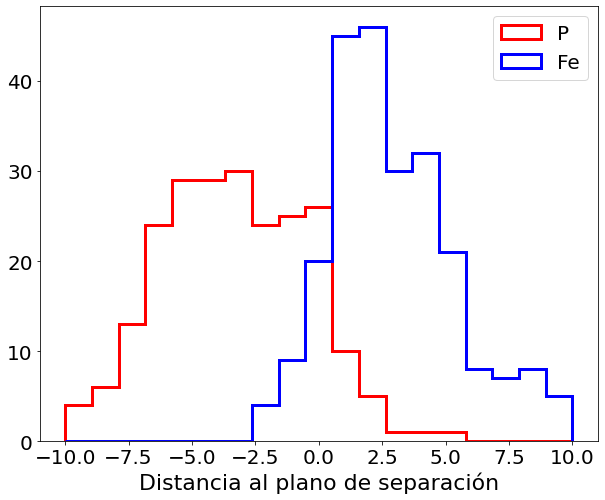

In [121]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [122]:
boostMF(c1_pred, c2_pred)

('1.43', '0.08')

## SVM Energia

In [113]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 10), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [114]:
model_svm_3 = rnd_search_cv.best_estimator_
model_svm_3

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=14.217320176830505, break_ties=False, cache_size=200,
                     class_weight=None, coef0=34.42239512391186,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.010225028523562073, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [160]:
print(accuracy(X_train, y_train, model_svm_3))
print(crossAccuracy(X_train, y_train, model_svm_3))

0.8975409836065574
Accuracy:  0.9036989795918368 0.04589129414159785
presicion:  0.8846433349259437 0.047183289706483895
recall:  0.93 0.05256213254594772
F1_score:  0.9061587624210665 0.044295930924573186
None


In [161]:
auc_cv(X_train, y_train, model_svm_3)

0.9571944444444442 0.03294172745026292


In [162]:
print(crossAccuracy(X_test, y_test, model_svm_3))

Accuracy:  0.8544871794871796 0.11121563952379945
presicion:  0.8454761904761906 0.095715766394612
recall:  0.869047619047619 0.16296919008235813
F1_score:  0.8513170163170163 0.12211507022722812
None


In [163]:
auc_cv(X_test, y_test, model_svm_3)

0.9111111111111112 0.09026709338484398


In [117]:
mconfusion(X_train, y_train, model_svm_3)

Matriz de confusión, 

[[214  30]
 [ 17 227]]
precisión:  0.8832684824902723
exhaustividad:  0.930327868852459


In [118]:
print(classification_report(y_train, model_svm_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [119]:
ypred = cross_val_predict(model_svm_3, X_train, y_train, cv=5, method="decision_function")

In [120]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

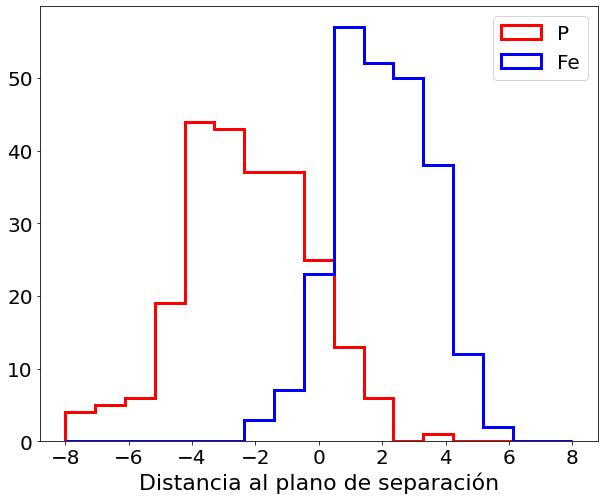

In [121]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 8, 18)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
plt.show()

In [122]:
boostMF(c1_pred, c2_pred)

('1.68', '0.09')

Saving figure plano_SVM_plot_best_ obs_3


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


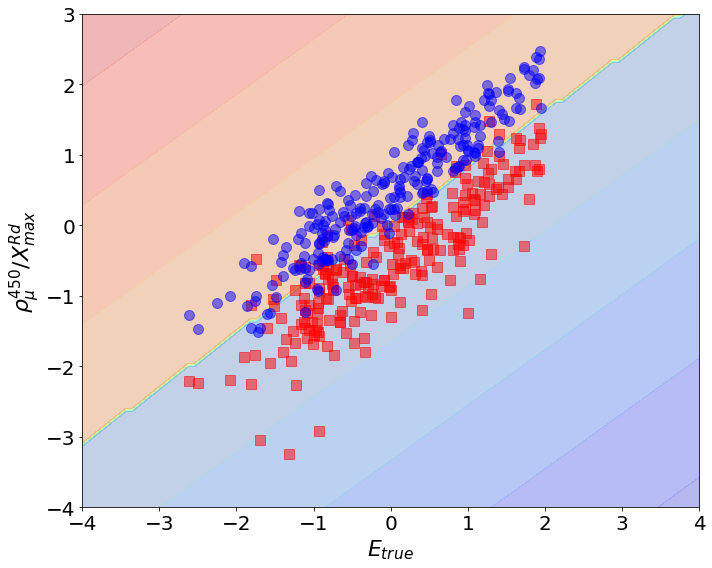

In [159]:
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_3,[-4, 4, -4, 3])
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")
plt.xlabel(r"$E_{true}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / X^{Rd}_{max}$", fontsize=22)

In [132]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [133]:
model_svm_3p = rnd_search_cv.best_estimator_
model_svm_3p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=432.3897479703097, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [134]:
print(accuracy(X_train, y_train, model_svm_3p))
print(crossAccuracy(X_train, y_train, model_svm_3p))

0.8975409836065574
Accuracy:  0.8852891156462585 0.04764515805051709
presicion:  0.8510060867252915 0.062203463316139185
recall:  0.9423333333333334 0.04244080845391875
F1_score:  0.8925992178184797 0.04055949717576056
None


In [135]:
mconfusion(X_train, y_train, model_svm_3p)

Matriz de confusión, 

[[202  42]
 [ 14 230]]
precisión:  0.8455882352941176
exhaustividad:  0.9426229508196722


In [136]:
print(classification_report(y_train, model_svm_3p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       244
           1       0.87      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [137]:
ypred = cross_val_predict(model_svm_3p, X_train, y_train, cv=5, method="decision_function")

In [138]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

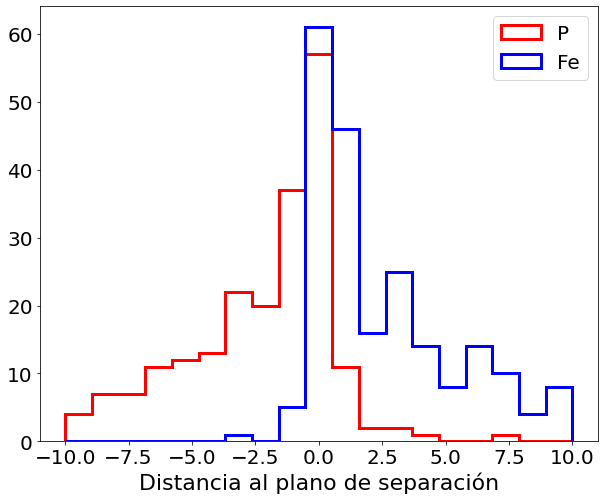

In [139]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [140]:
boostMF(c1_pred, c2_pred)

('0.63', '0.10')

In [184]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [185]:
model_svm_4 = rnd_search_cv.best_estimator_
model_svm_4

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=6.535079977997189, break_ties=False, cache_size=200,
                     class_weight=None, coef0=38.04005586963053,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.011904425695836865, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [186]:
print(accuracy(X_train, y_train, model_svm_4))
print(crossAccuracy(X_train, y_train, model_svm_4))

0.8995901639344263
Accuracy:  0.9037414965986393 0.046821321672639186
presicion:  0.879208637439522 0.04976685026272767
recall:  0.9381666666666666 0.05353321917796047
F1_score:  0.9069778628075522 0.045141611806994095
None


In [187]:
auc_cv(X_train, y_train, model_svm_4)

0.9580694444444445 0.0320510569970731


In [188]:
print(crossAccuracy(X_test, y_test, model_svm_4))

Accuracy:  0.8621794871794872 0.10765605311601424
presicion:  0.8404761904761905 0.10597244325841852
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8685897435897436 0.10099968754223544
None


In [189]:
auc_cv(X_test, y_test, model_svm_4)

0.9194444444444445 0.07662019196714656


In [190]:
mconfusion(X_train, y_train, model_svm_4)

Matriz de confusión, 

[[212  32]
 [ 15 229]]
precisión:  0.8773946360153256
exhaustividad:  0.9385245901639344


In [191]:
print(classification_report(y_train, model_svm_4.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       244
           1       0.87      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [192]:
ypred = cross_val_predict(model_svm_4, X_train, y_train, cv=5, method="decision_function")

In [193]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

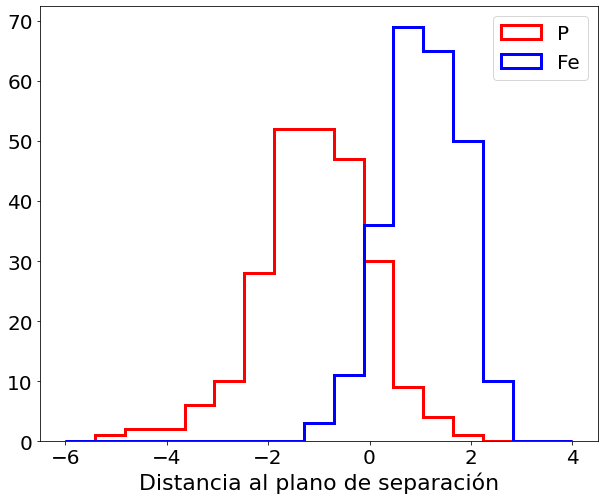

In [210]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 4, 18)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_3_hist_best")
plt.show()

In [211]:
boostMF(c1_pred, c2_pred)

('1.68', '0.09')

In [196]:
svcP=model_svm_4.named_steps['svm_clf']

Saving figure plano_SVM_plot_best_ obs_3


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


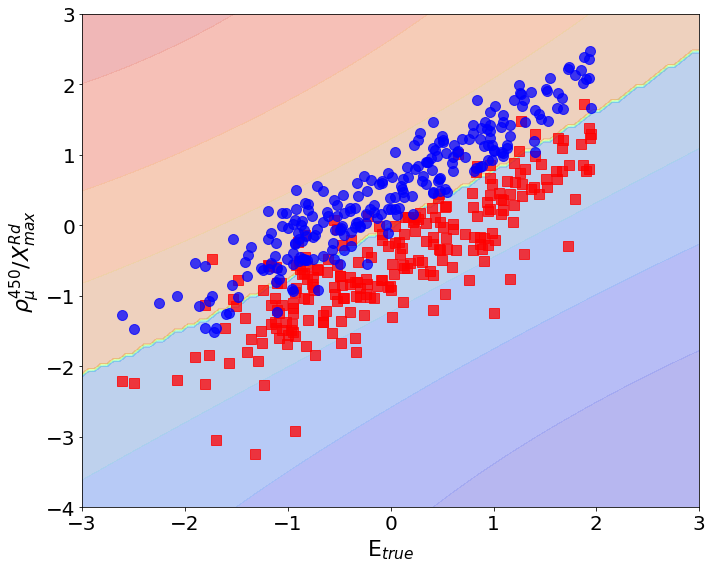

In [208]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_4,[-3, 3, -4, 3])
plot_dataset(XX, y,[-3, 3, -4, 3])
plt.xlabel(r"E$_{true}$")
plt.ylabel(r"$\rho^{450}_{\mu} / X^{Rd}_{max}$")
#save_fig("plano_SVM_plot_best_ obs_3")
plt.show()

## Variables individuales + Energía

In [455]:
#Features

df_train_2 = df_train[["MC energy", "GeoCeXmax", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "GeoCeXmax", "N_mu_ref", "target"]]

In [456]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 62)


In [457]:
df_train_2.head()

,MC energy,GeoCeXmax,N_mu_ref,target
246,3.824250e+17,610.506,0.850606,1
76,7.590210e+17,670.556,1.114180,1
171,6.116010e+17,669.154,1.146870,1
191,3.842740e+17,571.015,0.612265,1
75,9.452550e+17,599.145,1.232080,1


In [458]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC energy   -0.005095
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [459]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [460]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [461]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [462]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [463]:
X_train.head()

,MC energy,GeoCeXmax,N_mu_ref
0,-0.324464,-0.751797,0.462230
1,1.092195,0.260940,1.066291
2,0.651643,0.238489,1.133262
3,-0.314309,-1.481640,-0.224563
4,1.534527,-0.956135,1.301173


In [477]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [478]:
model_Log_5 = rnd_search_cv.best_estimator_
model_Log_5

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=24.22192357178601, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [479]:
print(accuracy(X_train, y_train, model_Log_5))
print(crossAccuracy(X_train, y_train, model_Log_5))

0.9036885245901639
Accuracy:  0.9016581632653061 0.04378386827614298
presicion:  0.8873356426182513 0.04487147873605523
recall:  0.9218333333333334 0.05385912694758015
F1_score:  0.9035309112806102 0.042414058766359064
None


In [480]:
print(crossAccuracy(X_test, y_test, model_Log_5))

Accuracy:  0.8621794871794872 0.09496054407471803
presicion:  0.8554761904761905 0.07913971972464419
recall:  0.869047619047619 0.1449255027955543
F1_score:  0.8584382284382285 0.10405402503431338
None


In [481]:
mconfusion(X_train, y_train, model_Log_5)

Matriz de confusión, 

[[215  29]
 [ 19 225]]
precisión:  0.8858267716535433
exhaustividad:  0.9221311475409836


In [482]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [483]:
ypred = cross_val_predict(model_Log_5, X_train, y_train, cv=5, method="decision_function")

In [484]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

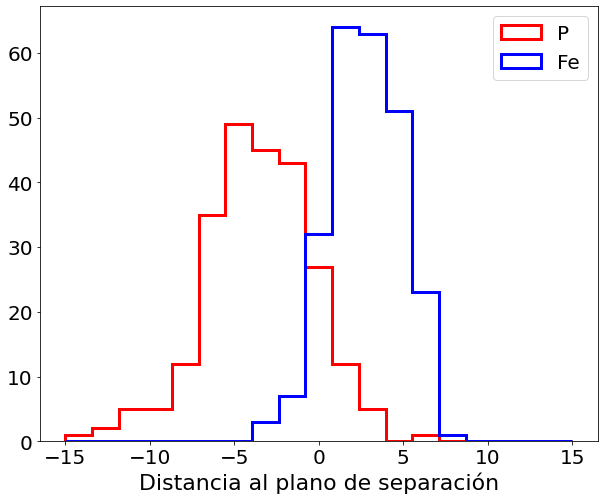

In [485]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 15, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [486]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')

In [487]:
from sklearn.preprocessing import PolynomialFeatures

In [171]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 19)

In [172]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 19)

In [173]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=200, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [174]:
model_Log_6 = rnd_search_cv.best_estimator_
model_Log_6

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.0116201474606346, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [175]:
print(accuracy(X_poly2, y_train, model_Log_6))
print(crossAccuracy(X_poly2, y_train, model_Log_6))

0.9057377049180327
Accuracy:  0.8873299319727892 0.04520619623642875
presicion:  0.8652792650434474 0.052621941864155135
recall:  0.9216666666666666 0.057120729842831834
F1_score:  0.8911813406430843 0.04312238831669518
None


In [176]:
mconfusion(X_poly2, y_train, model_Log_6)

Matriz de confusión, 

[[208  36]
 [ 19 225]]
precisión:  0.8620689655172413
exhaustividad:  0.9221311475409836


In [177]:
print(classification_report(y_train, model_Log_6.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       244
           1       0.89      0.93      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [178]:
ypred = cross_val_predict(model_Log_6, X_poly2, y_train, cv=5, method="decision_function")

In [179]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

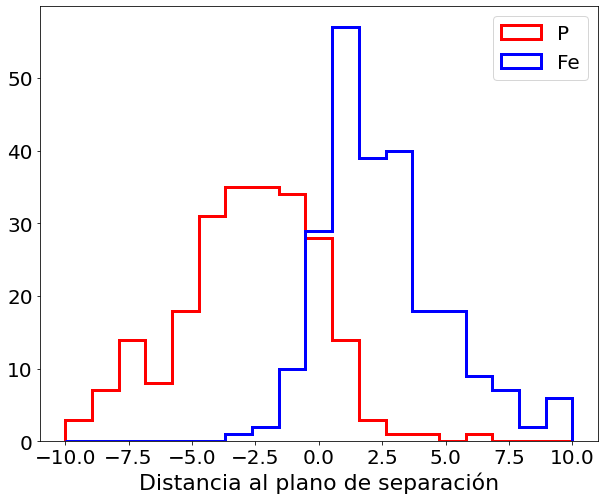

In [180]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [181]:
boostMF(c1_pred, c2_pred)

('1.22', '0.09')

## SVM Energia

In [490]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [491]:
model_svm_5 = rnd_search_cv.best_estimator_
model_svm_5

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.099212570376356, break_ties=False, cache_size=200,
                     class_weight=None, coef0=58.719933286723666,
                     decision_function_shape='ovr', degree=3,
                     gamma=4.673006919345381e-06, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [492]:
print(accuracy(X_train, y_train, model_svm_5))
print(crossAccuracy(X_train, y_train, model_svm_5))

0.8975409836065574
Accuracy:  0.9016581632653061 0.04378386827614298
presicion:  0.8848799775936207 0.04757544269955505
recall:  0.9259999999999999 0.051640853766933184
F1_score:  0.904149680800997 0.0417283842212192
None


In [493]:
print(crossAccuracy(X_test, y_test, model_svm_5))

Accuracy:  0.8621794871794872 0.10201173373615094
presicion:  0.8454761904761904 0.095715766394612
recall:  0.8857142857142858 0.12945025922922082
F1_score:  0.862983682983683 0.10538671641089536
None


In [494]:
mconfusion(X_train, y_train, model_svm_5)

Matriz de confusión, 

[[214  30]
 [ 18 226]]
precisión:  0.8828125
exhaustividad:  0.9262295081967213


In [495]:
print(classification_report(y_train, model_svm_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [496]:
ypred = cross_val_predict(model_svm_5, X_train, y_train, cv=5, method="decision_function")

In [497]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

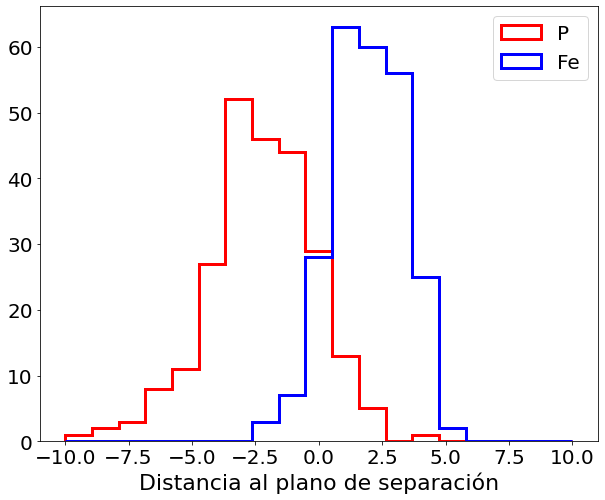

In [498]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [499]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')

In [191]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [192]:
model_svm_5p = rnd_search_cv.best_estimator_
model_svm_5p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=27.365314750100143, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [193]:
print(accuracy(X_train, y_train, model_svm_5p))
print(crossAccuracy(X_train, y_train, model_svm_5p))

0.8975409836065574
Accuracy:  0.8934523809523809 0.03643347782275638
presicion:  0.86150749697033 0.04852474944382433
recall:  0.9421666666666667 0.046583556946392324
F1_score:  0.8986714576817298 0.0334380657297642
None


In [194]:
mconfusion(X_train, y_train, model_svm_5p)

Matriz de confusión, 

[[206  38]
 [ 14 230]]
precisión:  0.8582089552238806
exhaustividad:  0.9426229508196722


In [195]:
print(classification_report(y_train, model_svm_5p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       244
           1       0.86      0.95      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [196]:
ypred = cross_val_predict(model_svm_5p, X_train, y_train, cv=5, method="decision_function")

In [197]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

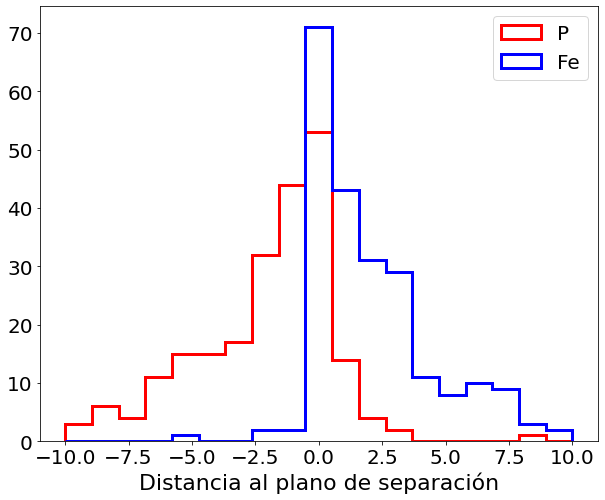

In [198]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [199]:
boostMF(c1_pred, c2_pred)

('0.80', '0.07')

In [522]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [523]:
model_svm_6 = rnd_search_cv.best_estimator_
model_svm_6

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=30.57690057625613, break_ties=False, cache_size=200,
                     class_weight=None, coef0=18.865636246311112,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.02137423685812129, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [524]:
print(accuracy(X_train, y_train, model_svm_6))
print(crossAccuracy(X_train, y_train, model_svm_6))

0.9036885245901639
Accuracy:  0.8954931972789115 0.04041254356798543
presicion:  0.8807924563359345 0.04610650569347405
recall:  0.9178333333333333 0.048910632790835976
F1_score:  0.8980214064750749 0.03785429373438044
None


In [525]:
print(crossAccuracy(X_test, y_test, model_svm_6))

Accuracy:  0.8544871794871796 0.12139103088784256
presicion:  0.8338095238095239 0.11810003830490085
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8641779788838612 0.10687604962996877
None


In [526]:
mconfusion(X_train, y_train, model_svm_6)

Matriz de confusión, 

[[213  31]
 [ 20 224]]
precisión:  0.8784313725490196
exhaustividad:  0.9180327868852459


In [527]:
print(classification_report(y_train, model_svm_6.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.93      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [528]:
ypred = cross_val_predict(model_svm_6, X_train, y_train, cv=5, method="decision_function")

In [529]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

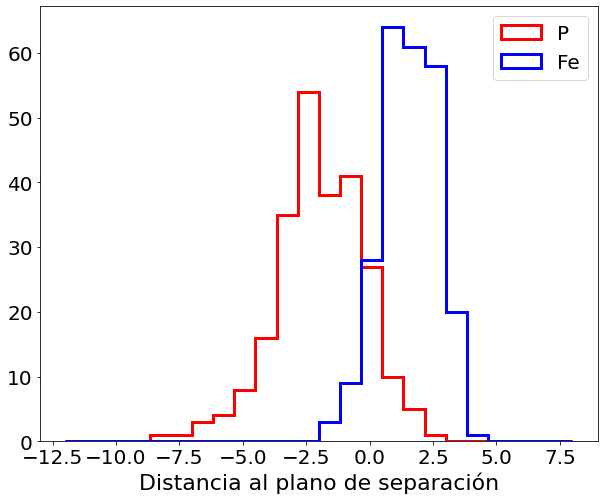

In [530]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-12, 8, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [531]:
boostMF(c1_pred, c2_pred)

('1.70', '0.09')

## Sumando el ángulo cenital

In [209]:
#Features

df_train_2 = df_train[["MC energy", "MC zenith", "GeoCeXmax", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "MC zenith", "GeoCeXmax", "N_mu_ref", "target"]]

In [210]:
print(df_train_2.shape, df_test_.shape)

(488, 5) (122, 62)


In [211]:
df_train_2.head()

,MC energy,MC zenith,GeoCeXmax,N_mu_ref,target
246,3.824250e+17,50.0277,610.506,0.850606,1
76,7.590210e+17,50.6696,670.556,1.114180,1
171,6.116010e+17,40.6307,669.154,1.146870,1
191,3.842740e+17,53.6568,571.015,0.612265,1
75,9.452550e+17,49.0955,599.145,1.232080,1


In [212]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC zenith    0.016190
MC energy   -0.005095
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [213]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 4) (488,) (488, 4) (122,)


In [214]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [215]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [216]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 4) (122, 4) (488,) (122,)


In [217]:
X_train.head()

,MC energy,MC zenith,GeoCeXmax,N_mu_ref
0,-0.324464,0.607596,-0.751797,0.462230
1,1.092195,0.757615,0.260940,1.066291
2,0.651643,-1.051059,0.238489,1.133262
3,-0.314309,1.527753,-1.481640,-0.224563
4,1.534527,0.398978,-0.956135,1.301173


In [218]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [219]:
model_Log_7 = rnd_search_cv.best_estimator_
model_Log_7

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=94.52339502485695, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [220]:
print(accuracy(X_train, y_train, model_Log_7))
print(crossAccuracy(X_train, y_train, model_Log_7))

0.9016393442622951
Accuracy:  0.8996598639455782 0.04346935115985386
presicion:  0.8876561554387642 0.05149370327240614
recall:  0.9176666666666667 0.04904759593157106
F1_score:  0.9015699183728089 0.04205252348893316
None


In [221]:
mconfusion(X_train, y_train, model_Log_7)

Matriz de confusión, 

[[215  29]
 [ 20 224]]
precisión:  0.8853754940711462
exhaustividad:  0.9180327868852459


In [222]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [223]:
ypred = cross_val_predict(model_Log_7, X_train, y_train, cv=5, method="decision_function")

In [224]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

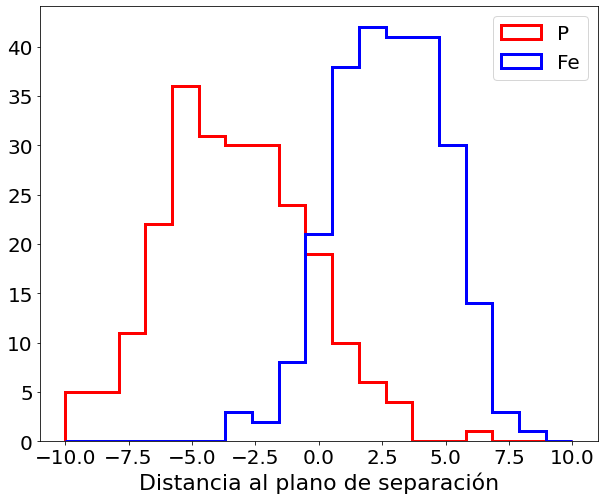

In [225]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [226]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')

In [227]:
from sklearn.preprocessing import PolynomialFeatures

In [228]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 34)

In [229]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 34)

In [230]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [231]:
model_Log_8 = rnd_search_cv.best_estimator_
model_Log_8

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=2.078354208520982, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [232]:
print(accuracy(X_poly2, y_train, model_Log_8))
print(crossAccuracy(X_poly2, y_train, model_Log_8))

0.9159836065573771
Accuracy:  0.8893707482993198 0.04517931645034746
presicion:  0.8891976261286606 0.06093261531807103
recall:  0.8968333333333334 0.07936711465644247
F1_score:  0.8895044376319495 0.04681215289160291
None


In [233]:
mconfusion(X_poly2, y_train, model_Log_8)

Matriz de confusión, 

[[215  29]
 [ 25 219]]
precisión:  0.8830645161290323
exhaustividad:  0.8975409836065574


In [234]:
print(classification_report(y_train, model_Log_8.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       244
           1       0.91      0.92      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [235]:
ypred = cross_val_predict(model_Log_8, X_poly2, y_train, cv=5, method="decision_function")

In [236]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

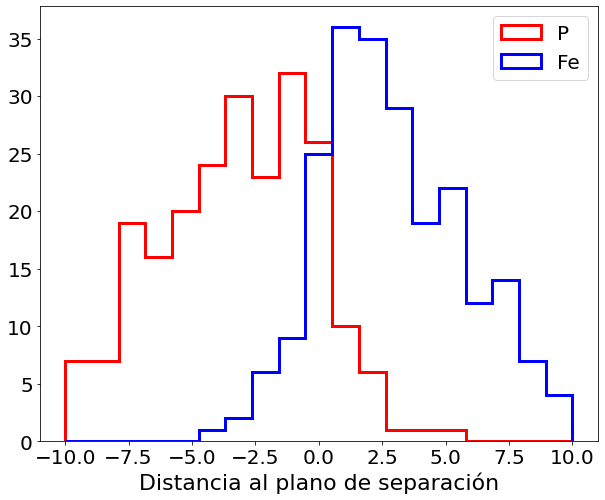

In [237]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [238]:
boostMF(c1_pred, c2_pred)

('1.23', '0.09')

## SVM Energia

In [239]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [240]:
model_svm_7 = rnd_search_cv.best_estimator_
model_svm_7

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=1.132310572570049, break_ties=False, cache_size=200,
                     class_weight=None, coef0=93.5139237293278,
                     decision_function_shape='ovr', degree=3,
                     gamma=2.9754516342595646e-06, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [241]:
print(accuracy(X_train, y_train, model_svm_7))
print(crossAccuracy(X_train, y_train, model_svm_7))

0.9036885245901639
Accuracy:  0.897576530612245 0.03996709453522345
presicion:  0.8834894887720974 0.04326260246482689
recall:  0.9176666666666667 0.04904759593157106
F1_score:  0.8995309112806102 0.03861605457942382
None


In [242]:
mconfusion(X_train, y_train, model_svm_7)

Matriz de confusión, 

[[214  30]
 [ 20 224]]
precisión:  0.8818897637795275
exhaustividad:  0.9180327868852459


In [243]:
print(classification_report(y_train, model_svm_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [244]:
ypred = cross_val_predict(model_svm_7, X_train, y_train, cv=5, method="decision_function")

In [245]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

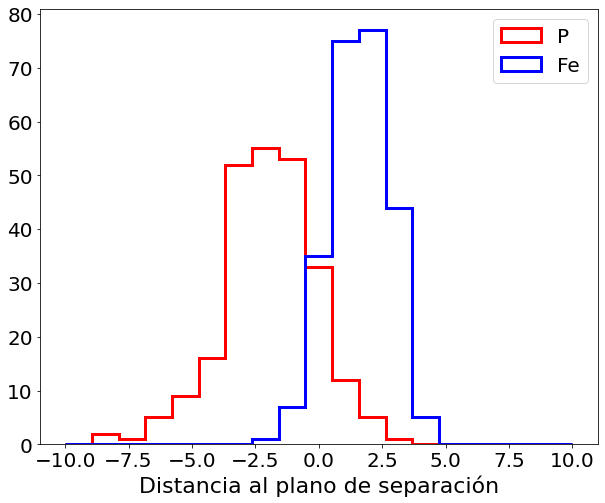

In [246]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [247]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')

In [248]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [249]:
model_svm_7p = rnd_search_cv.best_estimator_
model_svm_7p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=1.2533737396268543, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [250]:
print(accuracy(X_train, y_train, model_svm_7p))
print(crossAccuracy(X_train, y_train, model_svm_7p))

0.8995901639344263
Accuracy:  0.8852465986394558 0.04678974866815864
presicion:  0.8647427216503305 0.062027374277681735
recall:  0.9218333333333334 0.05053299252303719
F1_score:  0.8903050671978491 0.03959189256510419
None


In [251]:
mconfusion(X_train, y_train, model_svm_7p)

Matriz de confusión, 

[[207  37]
 [ 19 225]]
precisión:  0.8587786259541985
exhaustividad:  0.9221311475409836


In [252]:
print(classification_report(y_train, model_svm_7p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [253]:
ypred = cross_val_predict(model_svm_7p, X_train, y_train, cv=5, method="decision_function")

In [254]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

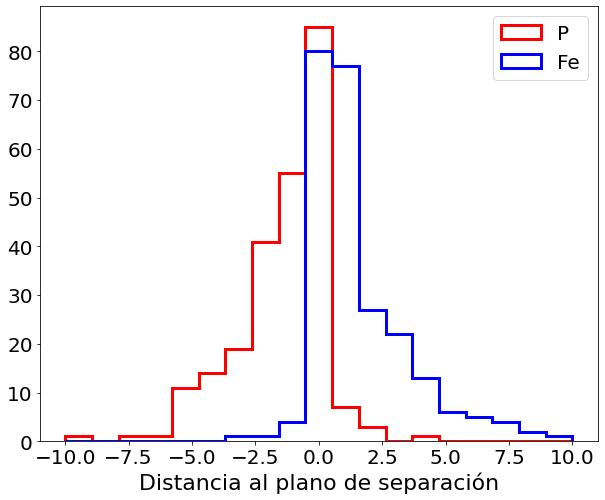

In [255]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [256]:
boostMF(c1_pred, c2_pred)

('0.92', '0.09')

In [257]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=200, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [258]:
model_svm_8 = rnd_search_cv.best_estimator_
model_svm_8

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=87.12754567134134, break_ties=False, cache_size=200,
                     class_weight=None, coef0=50.40013815832365,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.004881439949990507, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [259]:
print(accuracy(X_train, y_train, model_svm_8))
print(crossAccuracy(X_train, y_train, model_svm_8))

0.9036885245901639
Accuracy:  0.897576530612245 0.041999594006762064
presicion:  0.8784165444750152 0.04914170732186991
recall:  0.9258333333333335 0.048329022796291296
F1_score:  0.9006019304639649 0.039956168435252355
None


In [260]:
mconfusion(X_train, y_train, model_svm_8)

Matriz de confusión, 

[[212  32]
 [ 18 226]]
precisión:  0.875968992248062
exhaustividad:  0.9262295081967213


In [261]:
print(classification_report(y_train, model_svm_8.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       244
           1       0.88      0.93      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [262]:
ypred = cross_val_predict(model_svm_8, X_train, y_train, cv=5, method="decision_function")

In [263]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

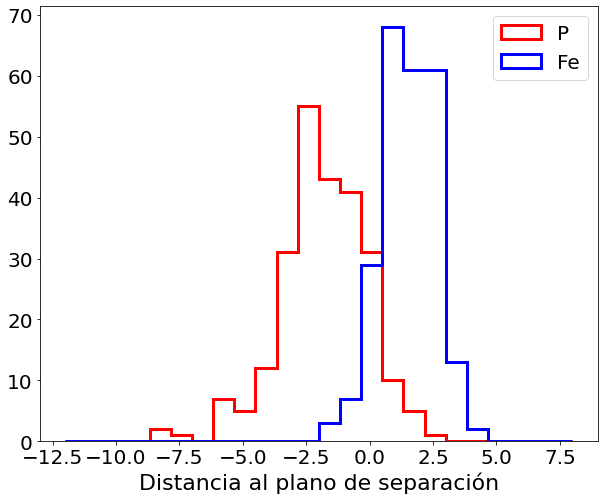

In [264]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-12, 8, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [265]:
boostMF(c1_pred, c2_pred)

('1.67', '0.09')

In [266]:
"Stations with Pulse"

'Stations with Pulse'

## Sumando estaciones de Radio

In [267]:
#Features

df_train_2 = df_train[["MC energy", "MC zenith", "Stations with Pulse", "GeoCeXmax", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "MC zenith", "Stations with Pulse", "GeoCeXmax", "N_mu_ref", "target"]]

In [268]:
print(df_train_2.shape, df_test_.shape)

(488, 6) (122, 62)


In [269]:
df_train_2.head()

,MC energy,MC zenith,Stations with Pulse,GeoCeXmax,N_mu_ref,target
246,3.824250e+17,50.0277,5,610.506,0.850606,1
76,7.590210e+17,50.6696,6,670.556,1.114180,1
171,6.116010e+17,40.6307,7,669.154,1.146870,1
191,3.842740e+17,53.6568,31,571.015,0.612265,1
75,9.452550e+17,49.0955,9,599.145,1.232080,1


In [270]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
N_mu_ref               0.384449
Stations with Pulse    0.031046
MC zenith              0.016190
MC energy             -0.005095
GeoCeXmax             -0.461443
Name: target, dtype: float64

In [271]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 5) (488,) (488, 5) (122,)


In [272]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [273]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [274]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 5) (122, 5) (488,) (122,)


In [275]:
X_train.head()

,MC energy,MC zenith,Stations with Pulse,GeoCeXmax,N_mu_ref
0,-0.324464,0.607596,-1.310774,-0.751797,0.462230
1,1.092195,0.757615,-0.712103,0.260940,1.066291
2,0.651643,-1.051059,-0.284582,0.238489,1.133262
3,-0.314309,1.527753,1.699532,-1.481640,-0.224563
4,1.534527,0.398978,0.285287,-0.956135,1.301173


In [276]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [277]:
model_Log_9 = rnd_search_cv.best_estimator_
model_Log_9

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.3906920907007393, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [278]:
print(accuracy(X_train, y_train, model_Log_9))
print(crossAccuracy(X_train, y_train, model_Log_9))

0.9016393442622951
Accuracy:  0.8996173469387754 0.04343167914141375
presicion:  0.8811872909698997 0.047320019290415655
recall:  0.9259999999999999 0.04844355248924027
F1_score:  0.9023749734337734 0.041565732643416634
None


In [279]:
mconfusion(X_train, y_train, model_Log_9)

Matriz de confusión, 

[[213  31]
 [ 18 226]]
precisión:  0.8793774319066148
exhaustividad:  0.9262295081967213


In [280]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [281]:
ypred = cross_val_predict(model_Log_9, X_train, y_train, cv=5, method="decision_function")

In [282]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

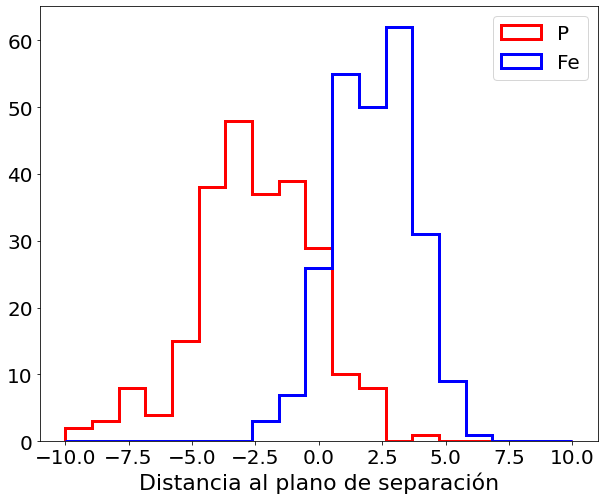

In [283]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [284]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')

In [285]:
from sklearn.preprocessing import PolynomialFeatures

In [286]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 55)

In [287]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 55)

In [288]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [289]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.78417177523842, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [290]:
print(accuracy(X_poly2, y_train, model_Log_10))
print(crossAccuracy(X_poly2, y_train, model_Log_10))

0.9180327868852459
Accuracy:  0.8749574829931973 0.05229918481585698
presicion:  0.8767327154265157 0.06276263220915844
recall:  0.8801666666666665 0.0882655400230212
F1_score:  0.8744489539536756 0.05391105023621447
None


In [291]:
mconfusion(X_poly2, y_train, model_Log_10)

Matriz de confusión, 

[[212  32]
 [ 29 215]]
precisión:  0.8704453441295547
exhaustividad:  0.8811475409836066


In [292]:
print(classification_report(y_train, model_Log_10.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       244
           1       0.92      0.92      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [293]:
ypred = cross_val_predict(model_Log_10, X_poly2, y_train, cv=5, method="decision_function")

In [294]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

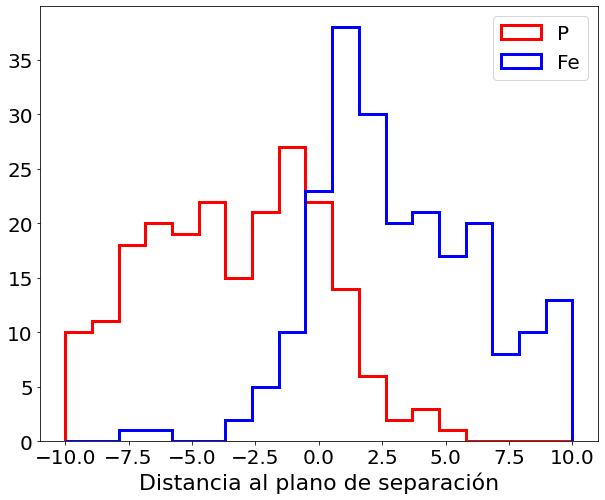

In [295]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [296]:
boostMF(c1_pred, c2_pred)

('1.16', '0.09')

## SVM Energia

In [297]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [298]:
model_svm_9 = rnd_search_cv.best_estimator_
model_svm_9

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=51.40231344305792, break_ties=False, cache_size=200,
                     class_weight=None, coef0=13.525387000891032,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00011293387187951995, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [299]:
print(accuracy(X_train, y_train, model_svm_9))
print(crossAccuracy(X_train, y_train, model_svm_9))

0.8995901639344263
Accuracy:  0.8996173469387754 0.045309027844217434
presicion:  0.8781264163400595 0.04804907624704903
recall:  0.9298333333333334 0.05246930319508519
F1_score:  0.9025178126691289 0.04349724375252822
None


In [300]:
mconfusion(X_train, y_train, model_svm_9)

Matriz de confusión, 

[[212  32]
 [ 17 227]]
precisión:  0.8764478764478765
exhaustividad:  0.930327868852459


In [301]:
print(classification_report(y_train, model_svm_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [302]:
ypred = cross_val_predict(model_svm_9, X_train, y_train, cv=5, method="decision_function")

In [303]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

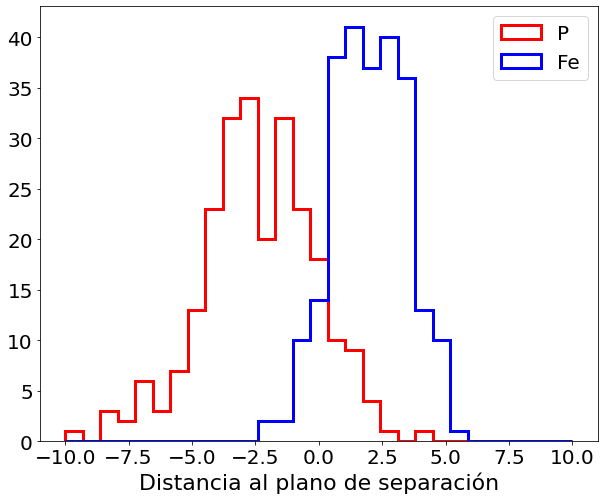

In [304]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 30)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [305]:
boostMF(c1_pred, c2_pred)

('1.63', '0.09')

In [306]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [307]:
model_svm_9p = rnd_search_cv.best_estimator_
model_svm_9p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=10.764742430469308, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [308]:
print(accuracy(X_train, y_train, model_svm_9p))
print(crossAccuracy(X_train, y_train, model_svm_9p))

0.9098360655737705
Accuracy:  0.8791666666666667 0.05356089951599373
presicion:  0.8714608519030099 0.07588271706567568
recall:  0.901 0.06515025368757636
F1_score:  0.8827422321585638 0.0486810573177439
None


In [309]:
mconfusion(X_train, y_train, model_svm_9p)

Matriz de confusión, 

[[209  35]
 [ 24 220]]
precisión:  0.8627450980392157
exhaustividad:  0.9016393442622951


In [310]:
print(classification_report(y_train, model_svm_9p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       244
           1       0.89      0.93      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [311]:
ypred = cross_val_predict(model_svm_9p, X_train, y_train, cv=5, method="decision_function")

In [312]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

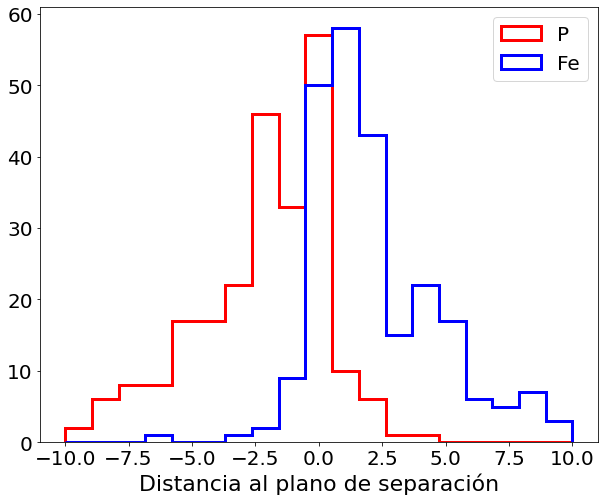

In [313]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [314]:
boostMF(c1_pred, c2_pred)

('0.98', '0.09')

In [315]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [316]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=81.34540676448242, break_ties=False, cache_size=200,
                     class_weight=None, coef0=34.87304387605455,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.005876703970121699, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [317]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.9077868852459017
Accuracy:  0.9058248299319727 0.039050545685732276
presicion:  0.8900638984259673 0.0510226047812975
recall:  0.9298333333333334 0.049325731396278126
F1_score:  0.9082479370999097 0.03736865701279989
None


In [318]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[215  29]
 [ 17 227]]
precisión:  0.88671875
exhaustividad:  0.930327868852459


In [319]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       244
           1       0.88      0.94      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [320]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [321]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

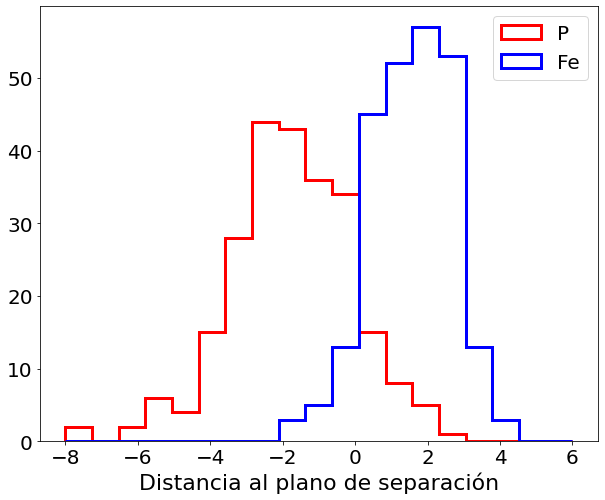

In [322]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [323]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')